In [15]:
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import cv2

In [11]:
def img2PCA(X, n):
    X -= X.mean(axis=0)
    U, S, A = np.linalg.svd(np.dot(X.T, X) / X.shape[0])    
    return np.dot(X, U[:, :n])

def img2PCAs(X, y, estimator, n, s):
    scores_total = np.zeros(s)
    for n in range(1, n):
        Xrot_reduced = img2PCA(X, n)
        scores = np.array([])
        for _ in range(s):
            source = Xrot_reduced
            x_train, x_test, y_train, y_test = train_test_split(source, y, test_size = 0.3)
            model = estimator().fit(x_train, y_train)
            score = model.score(x_test, y_test)
            scores = np.append(scores, score)
        print(n, np.mean(scores))
        scores_total = np.vstack((scores_total, scores))
    return scores_total

def img2polar(img):
    sobel_x = np.zeros_like(img)
    sobel_y = np.zeros_like(img)
    for i in range(len(img)):
        sobel_x[i] = cv2.Sobel(img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
        sobel_y[i] = cv2.Sobel(img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    return cv2.cartToPolar(sobel_x, sobel_y)

def img_prep(img):
    g, theta = img2polar(img)
    g = g.reshape(-1, 28 * 28).astype(np.float32)
    theta = theta.reshape(-1, 28 * 28).astype(np.float32)
    return np.hstack((g, theta))

In [7]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))
y = train[:, 0]

In [13]:
# PCA n_comp - model score
scores_total = img2PCAs(img_prep(train_img), y, rf, 20, 1)

1 0.23595238095238094
2 0.3385714285714286
3 0.5096031746031746
4 0.6625396825396825
5 0.7541269841269841
6 0.8003174603174603
7 0.8261111111111111
8 0.8509523809523809
9 0.8583333333333333
10 0.8725396825396825
11 0.8903174603174603
12 0.8979365079365079
13 0.8965873015873016
14 0.9075396825396825
15 0.9051587301587302
16 0.9061111111111111
17 0.91
18 0.9115079365079365
19 0.9121428571428571


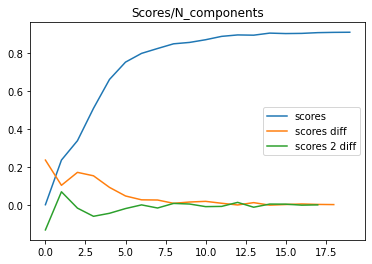

In [27]:
l = [np.mean(x) for x in scores_total]
plt.plot(l, label='scores')
plt.plot(np.diff(l), label='scores diff')
plt.plot(np.diff(l,2), label='scores 2 diff')
plt.title('Scores/N_components')
plt.legend()

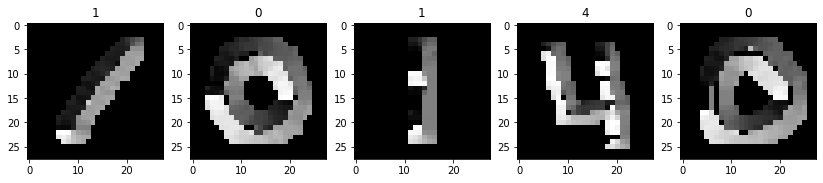

In [271]:
train_g, train_theta = img2polar(train_img)
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_theta[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title(f'{int(y[i - 1])}')

Для обучения модели используем совмещенные изображения углов и длин векторов градиента, редуцированных до 10 основных компонент (для простоты вычислений).

In [352]:
n = 10   # PCA components number

X = img_prep(train_img)
X -= X.mean(axis=0)
U, S, A = np.linalg.svd(np.dot(X.T, X) / X.shape[0])
X = np.dot(X, U[:, :n])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
model = rf().fit(x_train, y_train)
score = model.score(x_test, y_test)
print(score)

X_val = img_prep(test_img)
X_val -= X_val.mean(axis=0)
X_val = np.dot(X_val, U[:, :n])
y_val_pred = model.predict(X_val).astype('int')

0.8788888888888889

In [355]:
with open('submit.csv', 'w') as file:
    file.write('ImageId,Label\n')
    for i, p in enumerate(y_val_pred, 1):
        dst.write(f'{i},{p}\n')

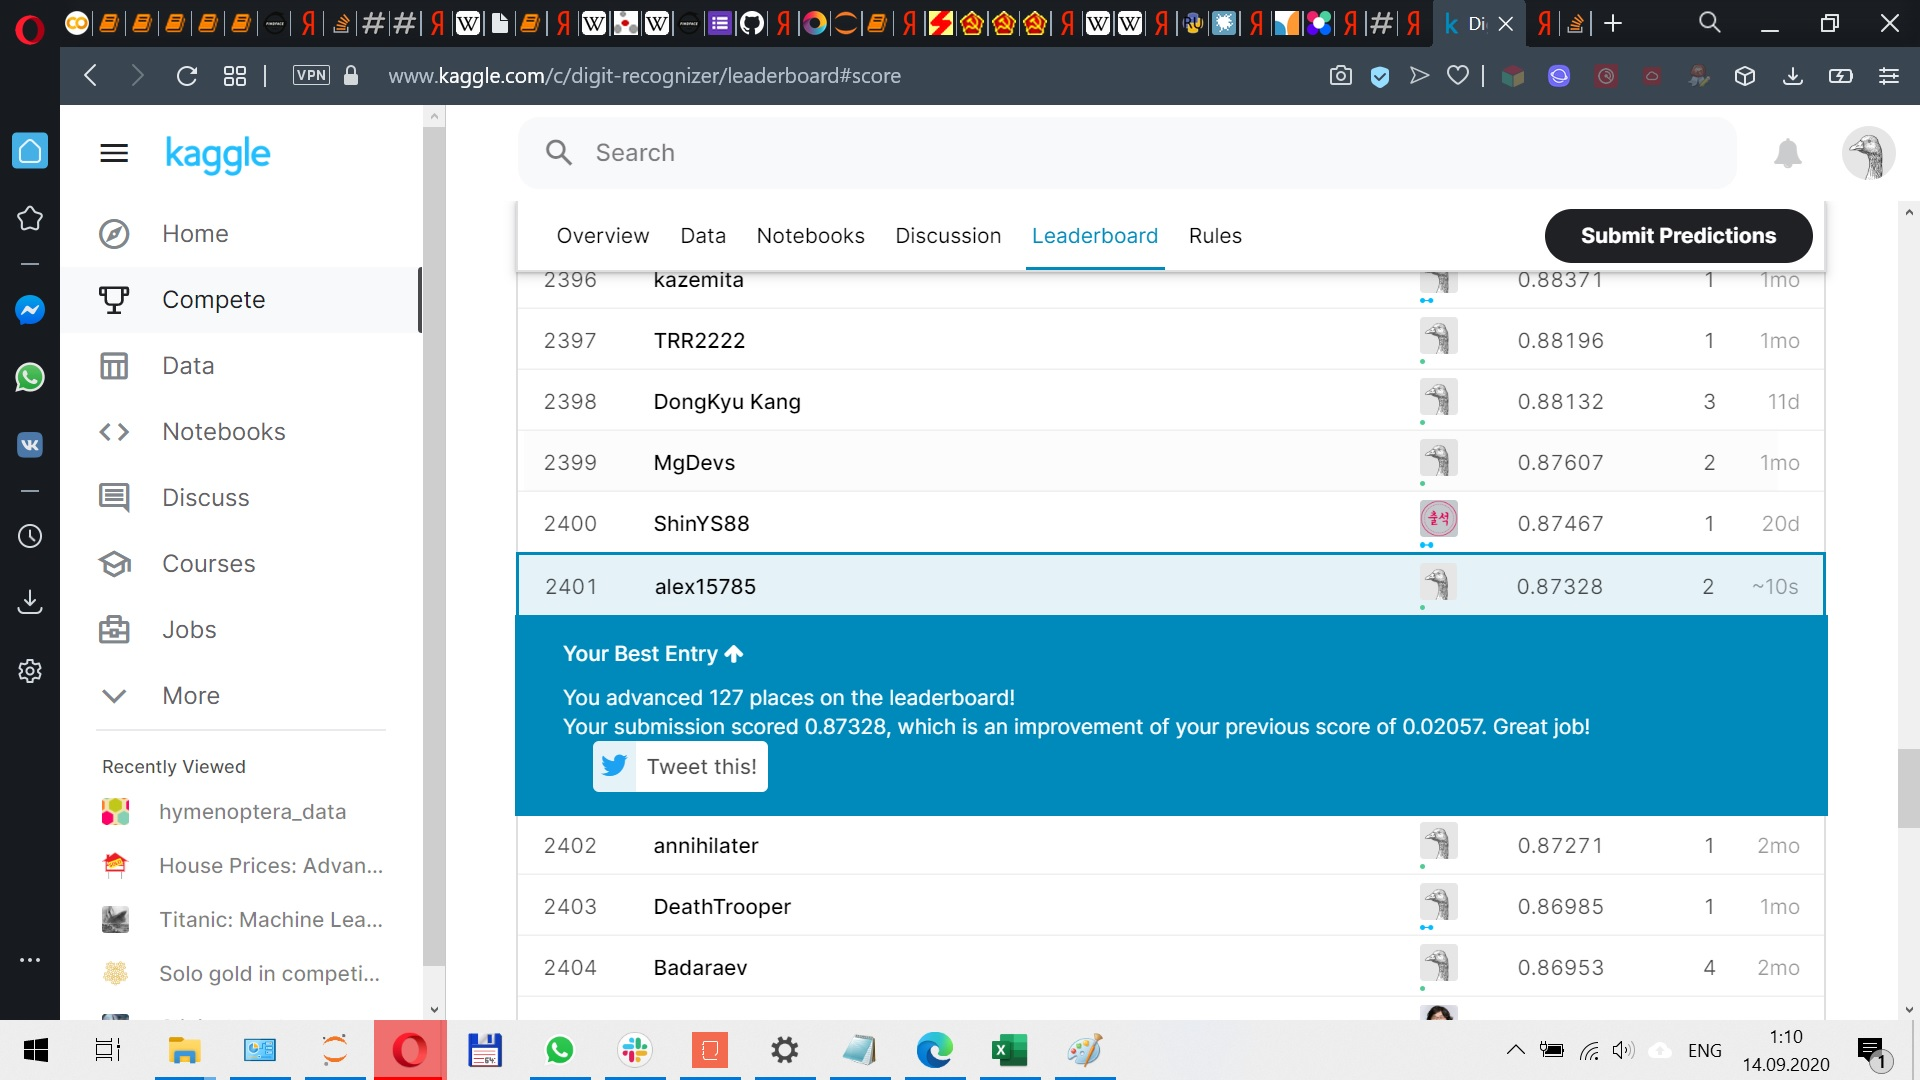

In [3]:
Image('kaggle_scoreboard.jpg')